# Setup

In [79]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(batchelor)
    library(patchwork)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [80]:
set.seed(319)
cols = sample(colorRampPalette(ggsci::pal_futurama()(12))(30))

# Read Data 

In [81]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")
log_info("SCE object done")

In [82]:
table(sce_complete$leiden_global_celltype)


                        B Cell                 Blood CD16+ NK 
                           657                            507 
               CD14+ Monocytes                      CD16- NK  
                           370                            309 
               CD16+ Monocytes           CD1c+ Dendritic Cell 
                           198                            318 
 CLEC9A+/LAMP3+ Dendritic Cell                    Endothelial 
                           118                           1189 
                   Hepatocytes                           ILCs 
                          1468                             37 
Liver bi-potent/Cholangiocytes                     Macrophage 
                           118                            579 
                     Mast Cell                     Mesenchyme 
                            58                            650 
                 Plasma B Cell             Proliferative T/NK 
                           270                        

In [83]:
sce <- sce_complete[, sce_complete$leiden_global_celltype %in% c("Hepatocytes", "Liver bi-potent/Cholangiocytes")]
sce <- logNormCounts(sce)

In [84]:
sce_old <- readRDS("../../../data/expression/sce/archive/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")
ov_cells <- intersect(colnames(sce_old), colnames(sce))
colData(sce)[ov_cells, "old_anno"] <- colData(sce_old)[ov_cells, 'celltype']

Warning message:
“Removed 2 rows containing missing values (geom_point).”


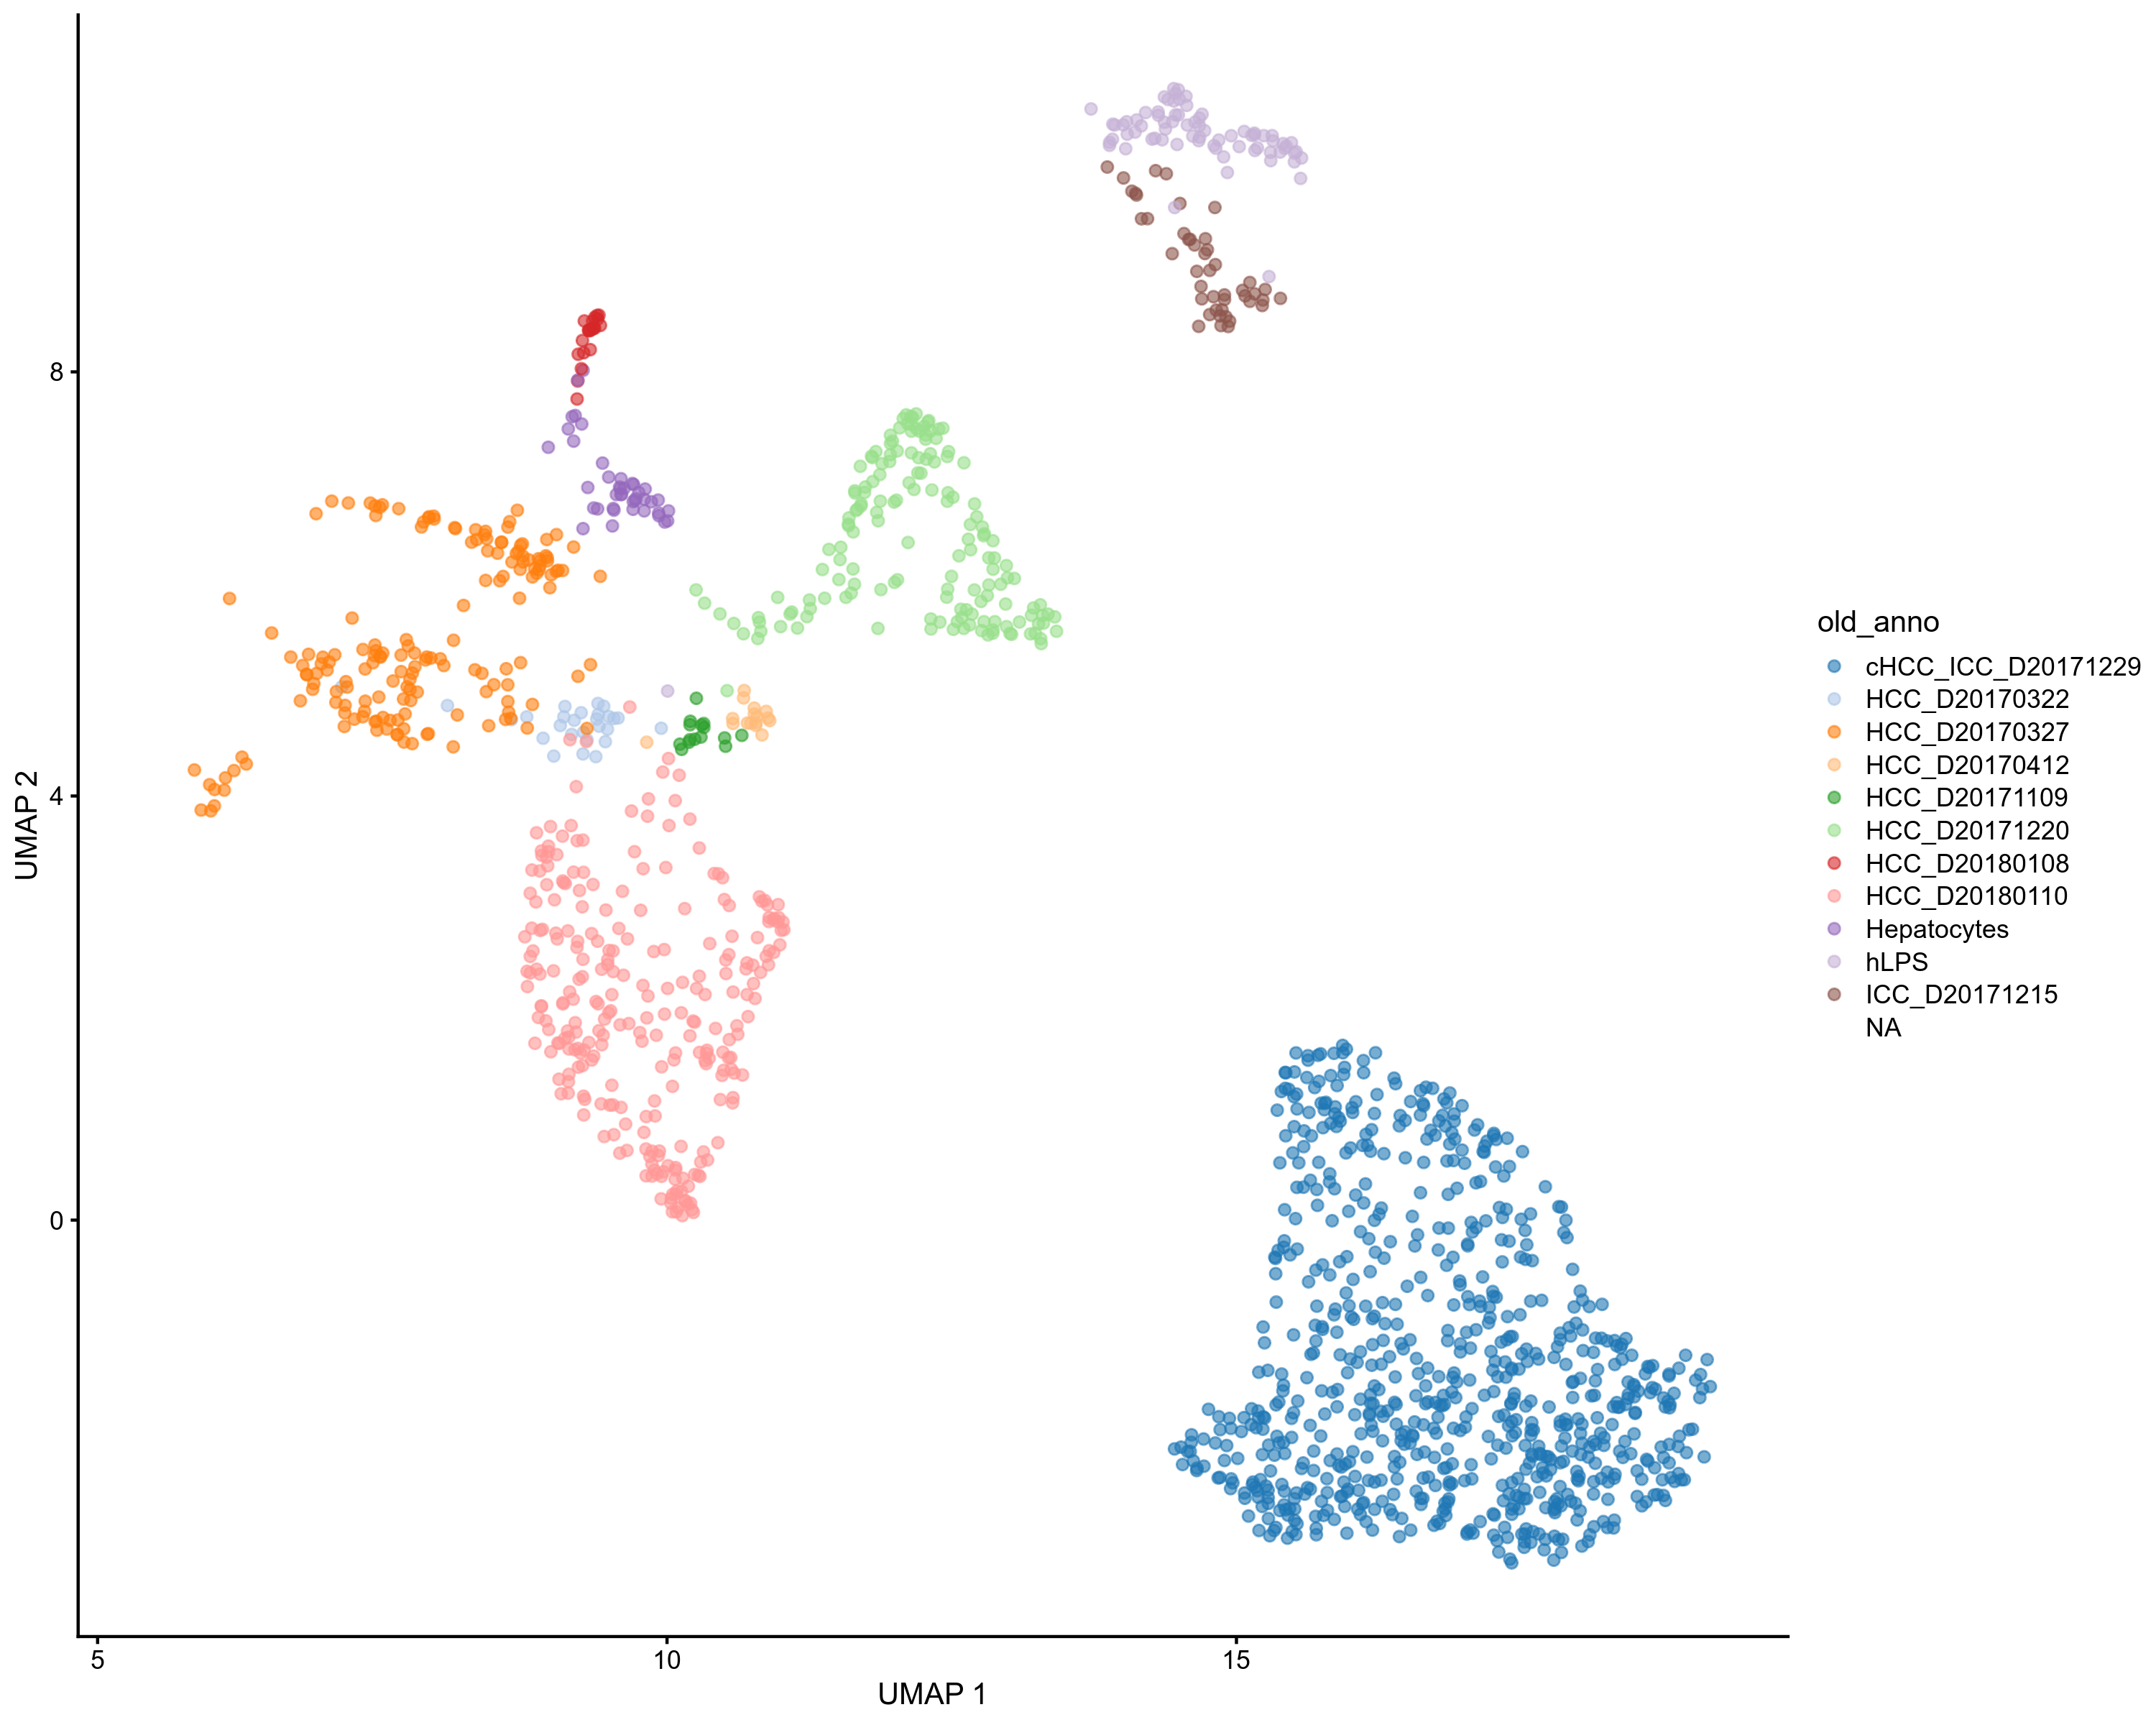

In [85]:
plotUMAP(sce, colour_by = "old_anno")

# Feature Selection

In [86]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep,  min.mean = 1, density.weights=FALSE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [87]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [88]:
#adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_pca" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$leiden(adata_sce, resolution = 1)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [89]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")

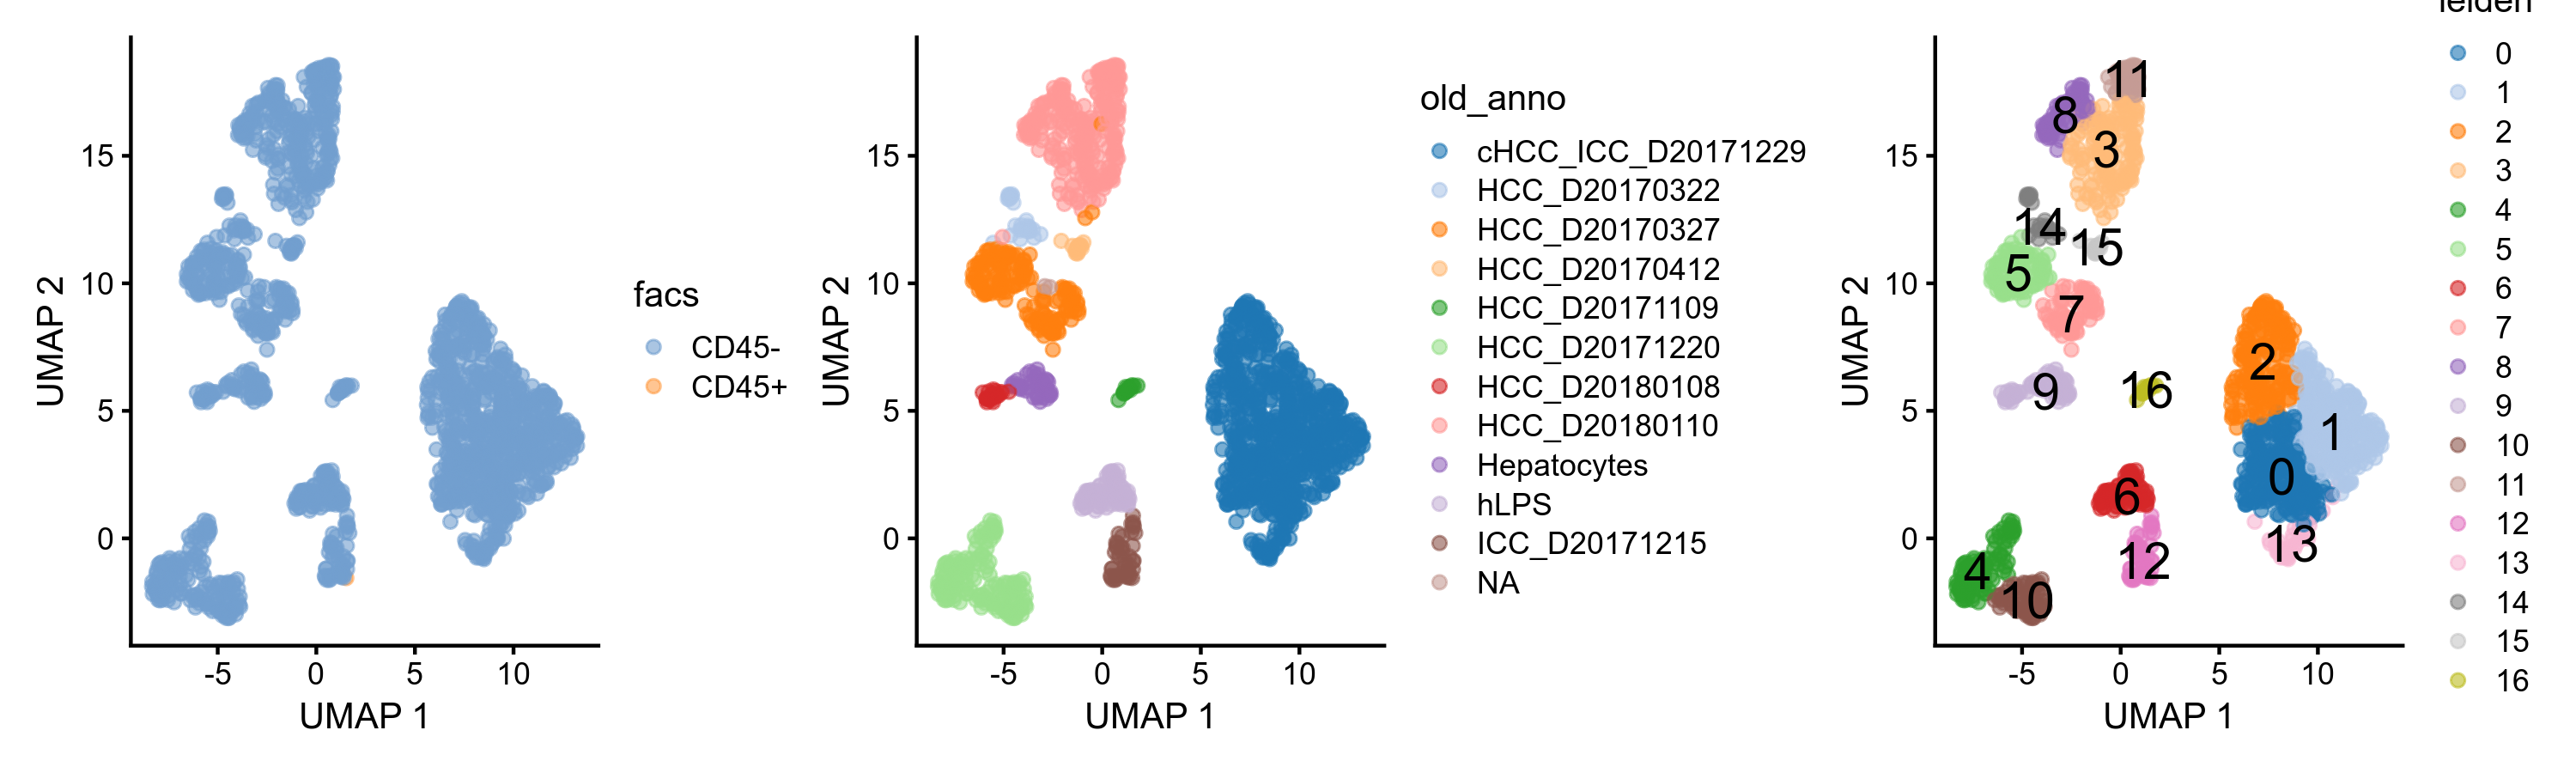

In [90]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'facs')
p2 <- plotUMAP(sce, colour_by = 'old_anno')
p3 <- plotUMAP(sce, colour_by = 'leiden', text_by = 'leiden')
library(patchwork)
p1 + p2 + p3

In [93]:
sce$leiden_sub <- case_when(nchar(as.character(sce$leiden)) == 1 ~ paste0("C0", as.character(sce$leiden)), 
         nchar(as.character(sce$leiden)) > 1  ~ paste0("C", as.character(sce$leiden)))


In [94]:
leidenEpi2celltype <- c(
    "C00" = "cHCC_ICC_D20171229",
    "C01" = "cHCC_ICC_D20171229",
    "C02" = "cHCC_ICC_D20171229",
    "C13" = "cHCC_ICC_D20171229",
    
    "C03" = "HCC_D20180110",
    "C08" = "HCC_D20180110",
    "C11" = "HCC_D20180110",
    
    "C05" = "HCC_D20170327",
    "C07" = "HCC_D20170327",
  
    "C04" = "HCC_D20171220",
    "C10" = "HCC_D20171220",
  
    
    "C09" = "Hepatocytes & D20180108",
    "C06" = "Liver bi-potent cells", 
    "C12" = "ICC_D20171215",
    
    "C14" = "HCC_D20170322",
    "C15" = "HCC_D20170412",
    "C16" = "HCC_D20171109"
 )

In [95]:
sce$leiden_anno <- plyr::mapvalues(sce$leiden_sub, from = names(leidenEpi2celltype), to = leidenEpi2celltype)

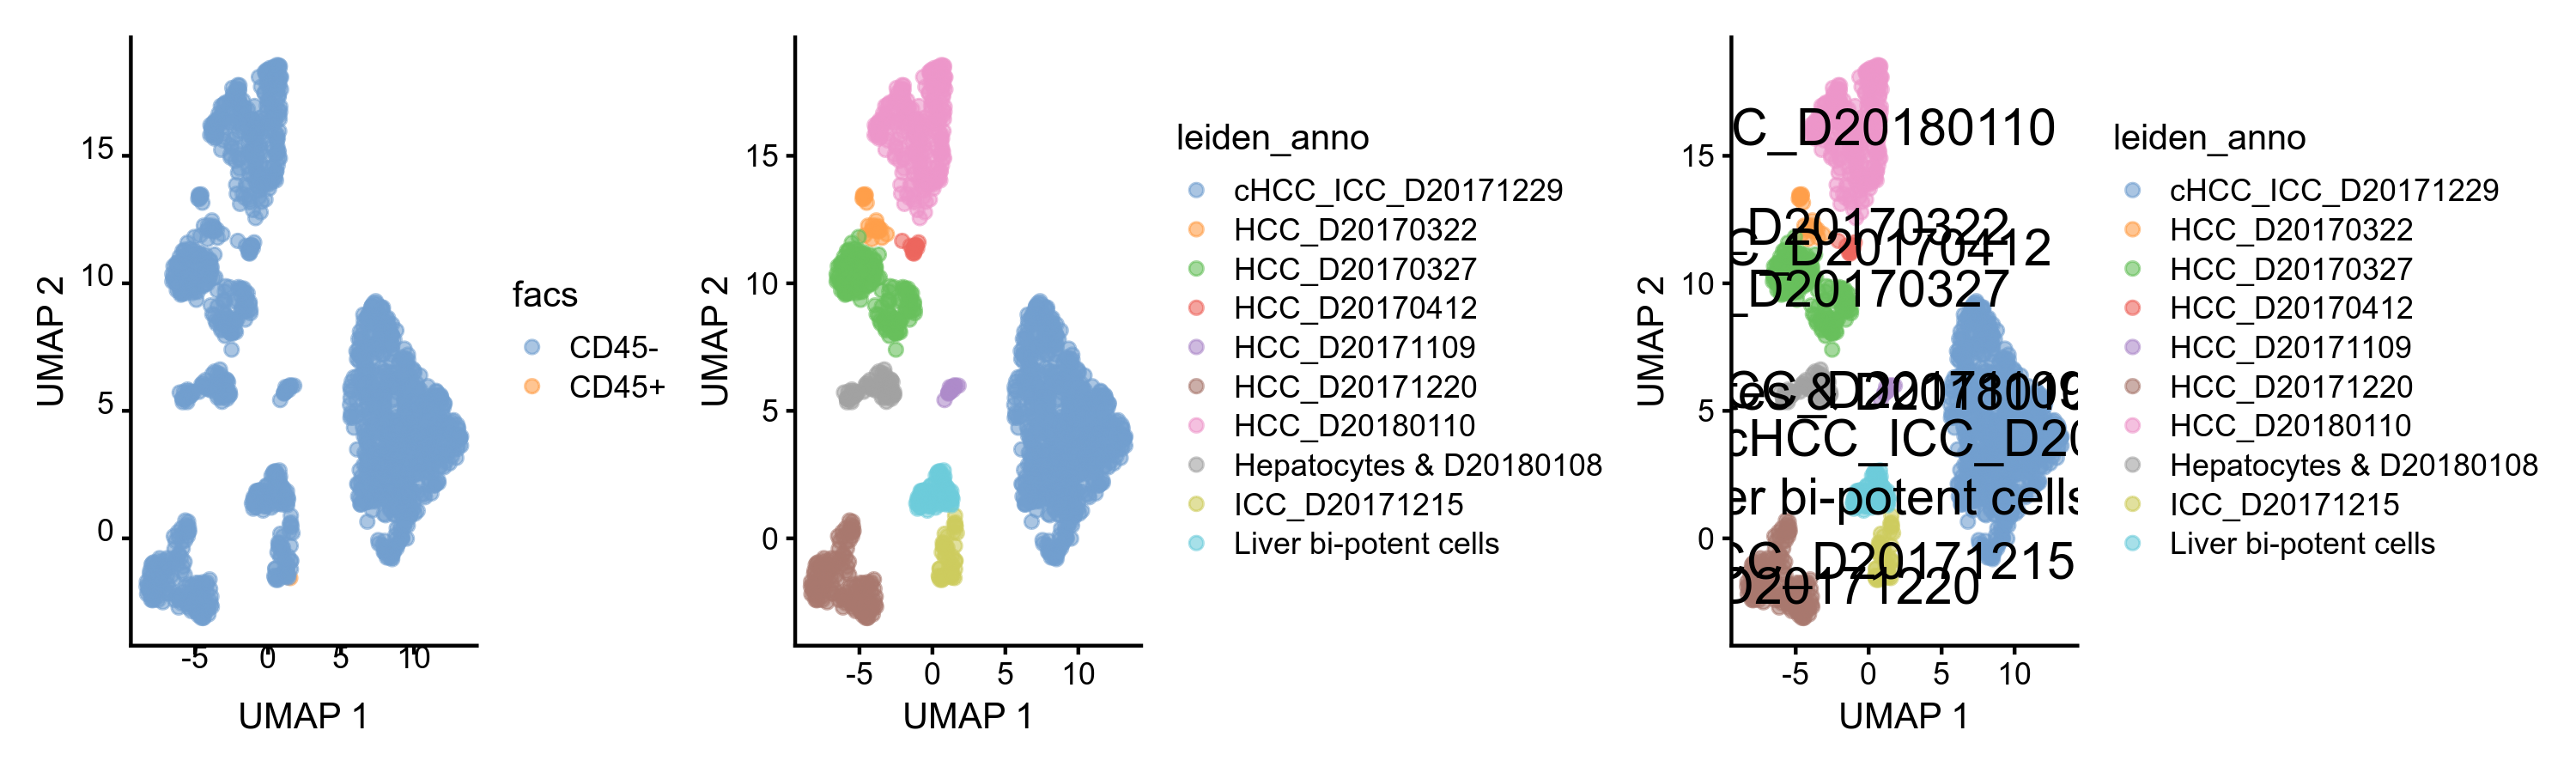

In [99]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'facs')
p2 <- plotUMAP(sce, colour_by = 'leiden_anno')
p3 <- plotUMAP(sce, colour_by = 'leiden_anno', text_by = 'leiden_anno')
library(patchwork)
p1 + p2 + p3

In [100]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_epithelial.rds")

In [111]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_epithelial.rds")

# Hepatocytes

In [112]:
sub <- logNormCounts(sce[, grepl("^HCC|^Hepatocytes", sce$leiden_anno)])

In [113]:
keep <- rowData(sub)$Biotype == "protein_coding"
dec <- modelGeneVar(sub, subset.row = keep,  min.mean = 1, density.weights=FALSE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [114]:
adata_sce <- zellkonverter::SCE2AnnData(sub, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [115]:
#adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_pca" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$leiden(adata_sce, resolution = 1)
log_info("Convert back to sce")
sub <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



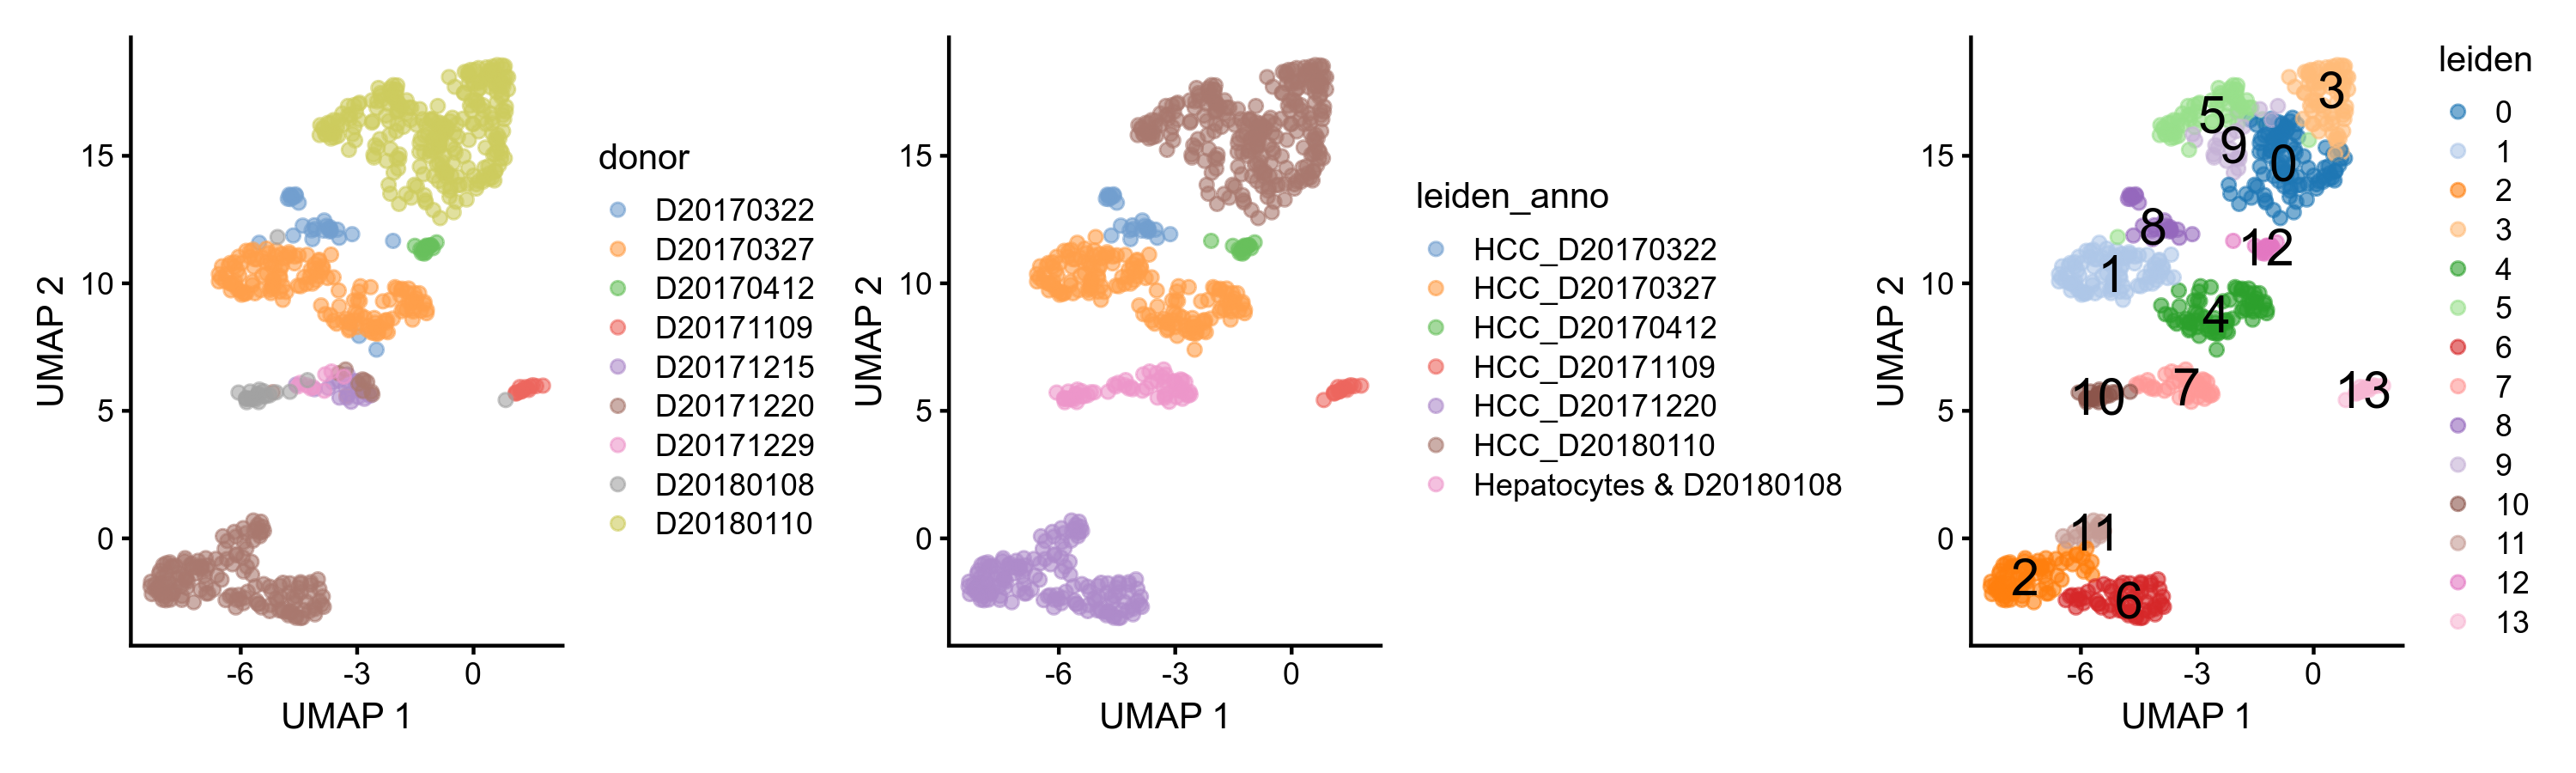

In [116]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)
p1 <- plotUMAP(sub, colour_by = 'donor')
p2 <- plotUMAP(sub, colour_by = 'leiden_anno')
p3 <- plotUMAP(sub, colour_by = 'leiden', text_by = 'leiden')
library(patchwork)
p1 + p2 + p3

In [118]:
colData(sce)[colnames(sub[, sub$leiden == '10']), 'leiden_anno'] <- 'HCC_D20180108'
colData(sce)[colnames(sub[, sub$leiden == '7']), 'leiden_anno'] <- 'Hepatocytes'

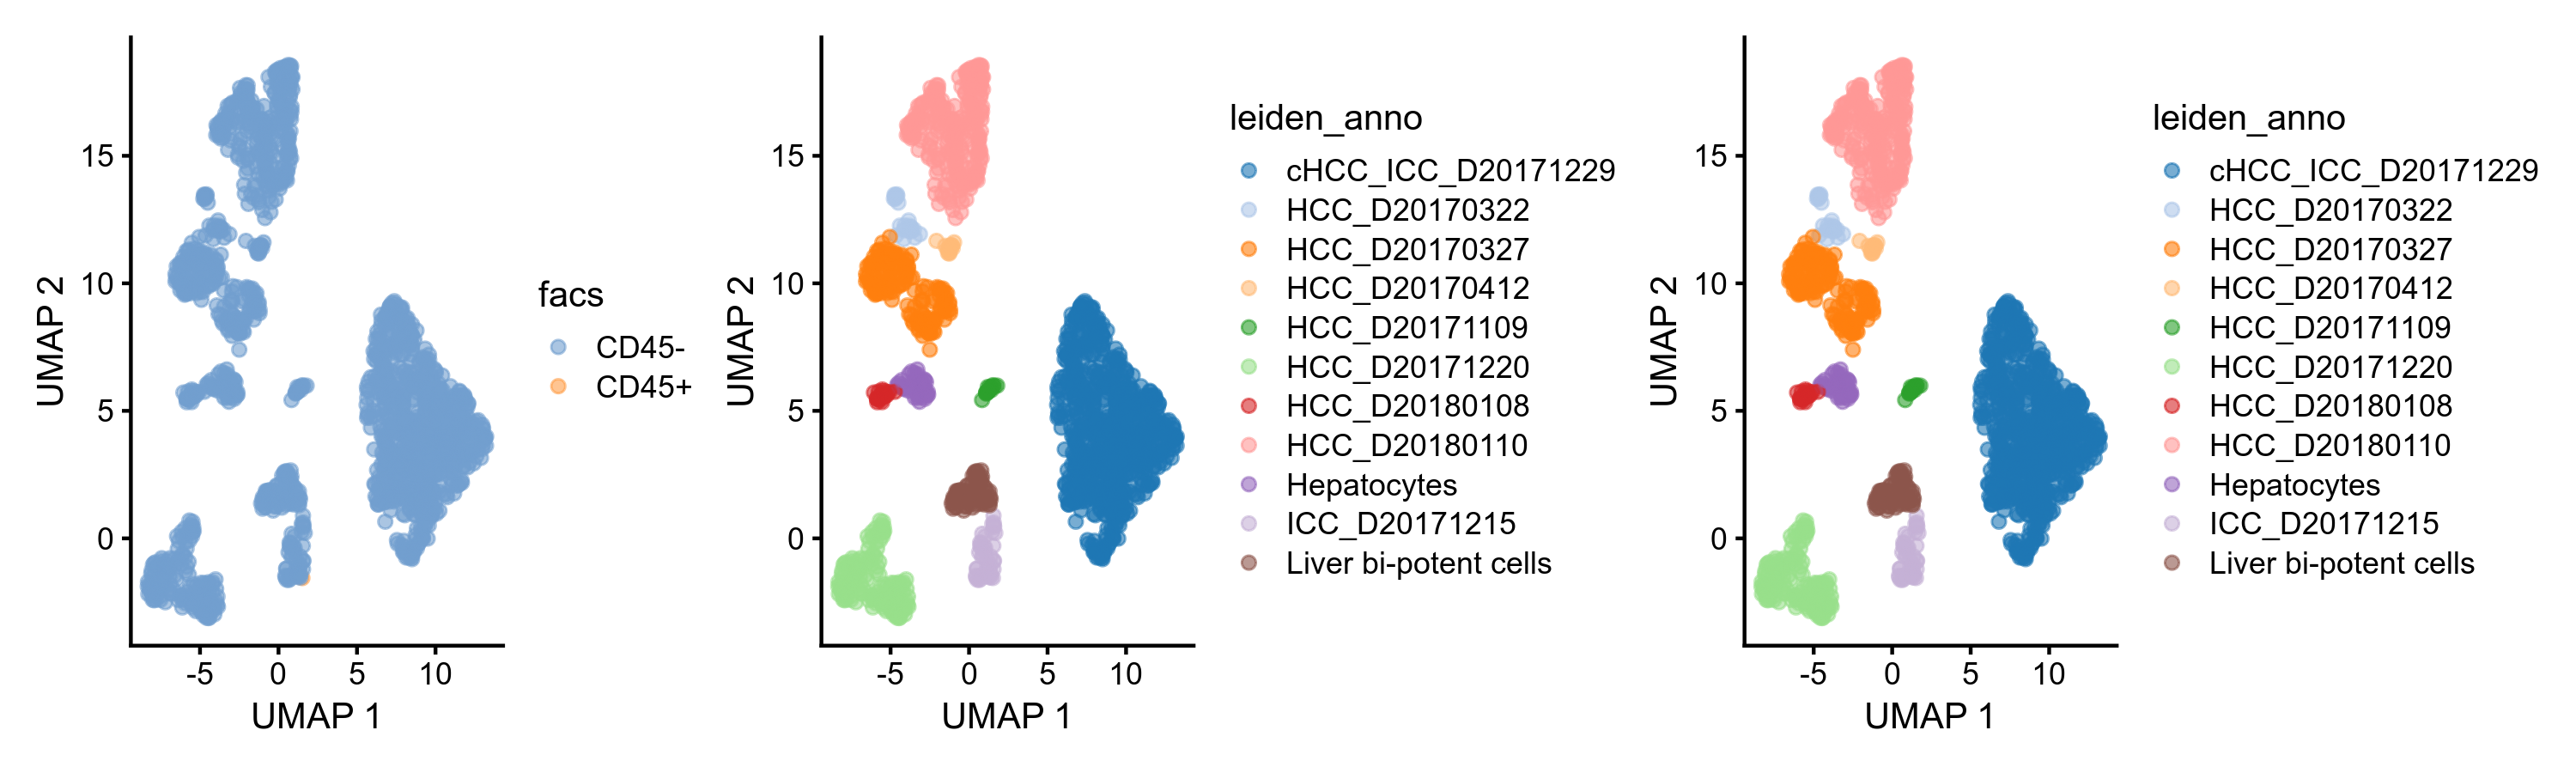

In [120]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'facs')
p2 <- plotUMAP(sce, colour_by = 'leiden_anno')
p3 <- plotUMAP(sce, colour_by = 'leiden_anno')
library(patchwork)
p1 + p2 + p3

In [121]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_epithelial.rds")